# MINIMAL SCAFFOLD

## Introduction
This jupyter notebook contains an overview of the software package, which highlights the main features and functions. The present library's objectives are as follows:
-  To provide an implementation of the Shortest Homology Basis algorithm introduced in __[*Dey, Li, Wang: Efficient algorithms for computing a minimal homology basis. (2018)*](https://doi.org/10.1007/978-3-319-77404-6_28)__
-  To employ the shortest homology basis to construct the Minimal Homological Scaffold (to appear)
-  To compare the minimal scaffold to the original homological scaffold, defined in __[*Petri, Expert, Turkheimer, Carhart-Harris, Nutt, Hellyer, Vaccarino: Homological scaffolds of brain functional networks. (2014)*](https://doi.org/10.1098/rsif.2014.0873)__. To this end, it incorporates the original python2 library Holes, which depends on jython and JavaPlex. Notice that, however, in order to experiment with the minimal scaffold these are not required. A full account of the dependencies is given below and in the main Readme file.

### Hypotheses
The present library works by taking as input a graph with non-negative weights $G$, represented by an adjacency matrix $W$. It constructs the filtration of simplicial complexes $(K_\varepsilon)$ induced by the weighting, and for each filtration step $\bar{\varepsilon}$ computes minimal representatives of a basis of $H_1(K_{\bar{\varepsilon}})$. These minimal representatives are used to build the minimal homological scaffold of the input network $MS(W)$.<br><br>
Additionally, it can pass the same input network to the Holes/JavaPlex implementation of the loose homological scaffold defined in *Petri et al. (2014)*, to use for comparison. Package Holes needs to be set up properly (see [Dependencies for Holes](#HolesDependencies)). <br><br>
**Remarks:** Regarding the uniqueness of minimal representatives, see [here](#Draws). Regarding the possibility of running a multithreaded version of the algorithm, see [here](#Parallel). 

## Example Pipeline
In order to showcase the usage of the package, we shall set up the computation of the minimal and loose homological scaffolds of a clique complex built on top of a simple weighted graph.
### Libraries

In [1]:
import sys
sys.path.append('./src') # add the source code to the path

# These are the main files in MinScaffold/src/

import Driver
import Geometry
import Scaffold

# These libraries are used throughout the code

import math
import numpy as np
from random import random
import networkx as nx
import pickle as pk
import matplotlib.pyplot as plt

### A basic graph
We use a pair of test functions, embedded directly into the library, to produce a simple example of a weighted graph that will serve as input. 
-  Driver.sampleCircle(x,y,radius,NV,noise) - Sample points in a noisy circle shape <br>
     `INPUT: average x coordinate, average y coordinate, radius, number of points, noise intensity` <br>
     `OUTPUT: A list of NV points on the plane, sampled uniformly with the above parameters`
     
-  Driver.points2adj(Points, threshold) - Compute the resulting distance matrix <br>
    `INPUT: A list of points in the plane, a threshold value` <br>
    `OUTPUT: A tuple of two matrices $W,A$. $W$ is the weigthed adjacency matrix with Euclidean distances as weights; All distances > threshold are cut off to zero. $A$ is the unweighted (0-1) adjacency matrix, with the same edge cutoff`

In [2]:
# Set parameters
NV = 35 
x = 0
y = 0
r = 3
noise = 3

# Generate a sample of NV points, in a noisy circle shape
P = Driver.sampleCircle(x,y,r,NV,noise)

# Return a distance matrix for the points, with all edges longer than 4 cut off.
# We fix threshold=4 to obtain a graphically interesting case
W,_ = Driver.points2adj(P,4)

### Visualization
We now forget about the points $P$ and employ *networkx* to represent the distance matrix $W$ as a graph $G$, and draw it. This is to emphasize the fact that the library is intended to be used with any weighted graph, including those that cannot be embedded in a metric space (like correlation networks).
We use a **layout** object to fix a layout for the nodes; this will be useful later to compare the input to the scaffolds. Passing *pos=layout* to nx.draw will maintain all nodes in the original position.

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


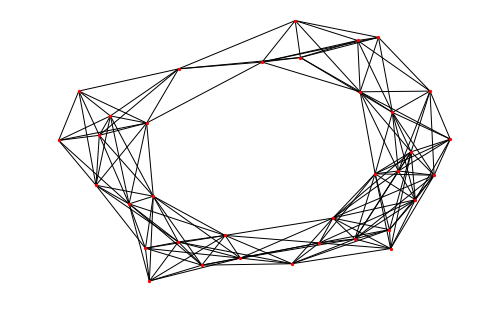

In [3]:
G = nx.Graph(W) # create a nx object

# Fix a layout for graph G. Node positions are chosen trying to minimize edge crossings.
layout = nx.drawing.layout.spring_layout(G)

# Plot the input weighted graph.
nx.draw(G, pos=layout, node_size=5)

Notice that by fiddling with the threshold in `Driver.points2adj` we can range from a totally disconnected graph to a complete one. In this case we chose a threshold of 4 as a distance cutoff to obtain a well-visible cycle. Other choices of parameters would require different threshold values to obtain an aesthetically-pleasing plot. This is, however, only a matter of visual appeal: one can choose to include all edges, hence extending the filtration until $H_1$ is trivial.

## Scaffold
We now set up the computation of the minimal homology bases. <br>
Firstly, we obtain a list of floating point numbers containing the filtration step values. For each value $\varepsilon$ in the list, a clique complex $K_{\varepsilon}$ will later be created that includes all vertices and all edges with weight $\leq \varepsilon$ .

In [4]:
epsList = Geometry.genFullEpsList(W)

Notice the list `epsList` can be manually modified to suit the user's preference. For example, it can be sliced to exclude from the computation a range of values, or it can be subsampled, or even extended.
### Computation
Next comes the heavy part of the algorithm. It computes the minimal representatives $b_i$ of the basis of $H_1(K_\varepsilon)$, for every step $\varepsilon$ in the filtration. Given the weighted graph $W$ and the list of filtration steps, it returns an object of class `Geometry.Filtration` containing a sequence of homology bases, indexed by filtration value. <br> 
For what concerns the uniqueness of the $b_i$'s (`Draws=False`), see [here](#Draws). For what concerns multithreading (`parallel=False, monitor=None` ), see [here](#Parallel).

In [5]:
F = Driver.getFiltrBasis(W, epsList, Draws=False, parallel=False, monitor=None)

Object $F$ contains a sequence of objects of class `Geometry.Basis`, indexed by step $\varepsilon$, each containing a minimal basis of $H_1(K_\varepsilon)$. Instances of this class can both be manually explored, or used transparently to obtain the scaffold. Function `Scaffold.frequency_Scaffold(F, NV)` takes as arguments the sequence of bases $F$ and the number of nodes of the input graph $NV$, and returns the *numpy* weighted adjacency matrix of the minimal scaffold.

In [8]:
S = Scaffold.frequency_Scaffold(F , NV)

The matrix can be passed to *networkx* for visualization, using the node layout object `layout` we had created in the beginning.

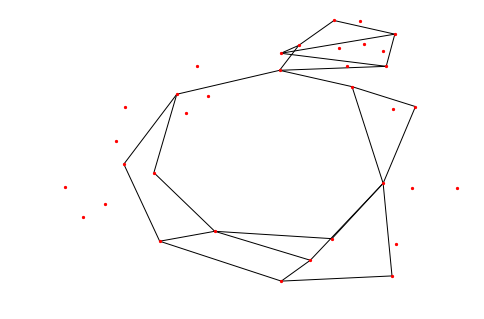

In [9]:
Scaf = nx.from_numpy_matrix(S, parallel_edges=False)
nx.draw(Scaf,pos=layout, node_size=5)

This above is the Minimal Homological Scaffold of the input graph. The main feature we can see is that the large, long-persistence cycle that was apparent in the input graph is tightly represented.
### Exploring Bases
As mentioned, we can also explore the minimal bases manually at each step of the filtration

In [28]:
# Create a list of homology bases
Bas = []
for (step,B) in F.Elements: 
    Bas.append(B) # store the basis, discarding the filtration step value

Function `Scaffold.matrix_Basis` provides a representation of basis $B$ in matrix form, given information about the number of vertices in the original graph, and the ordering of the original edges. This mapping is retrieved from the `Filtration` object through method `get_edgeList`.

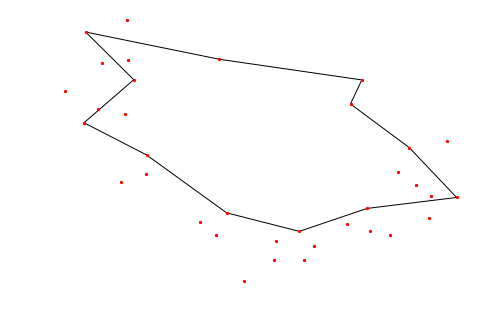

In [29]:
# Depending on the length of the filtration, choose a suitable step that contains nontrivial homology
B = Bas[130] 
M = Scaffold.matrix_Basis( B , NV , np.array(F.get_edgeList()) )

# Plot the basis at the given step, using the layout object as done above
nx.draw( nx.Graph(M) , pos = layout , node_size=5 )

One can also plot all steps at once

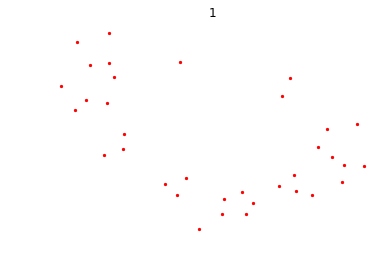

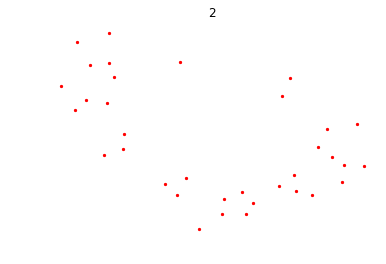

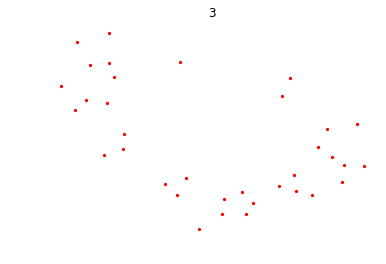

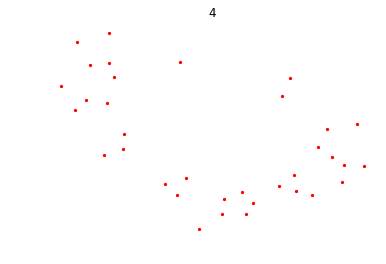

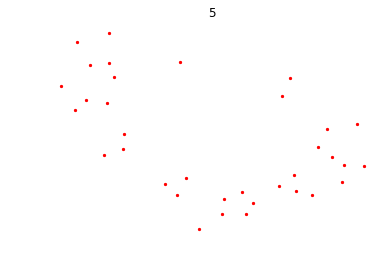

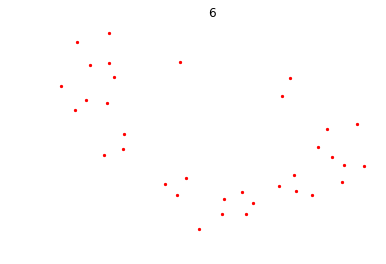

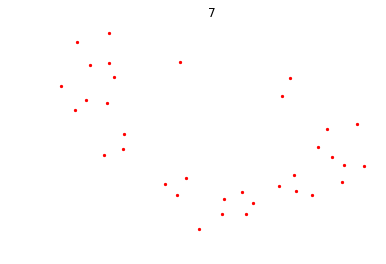

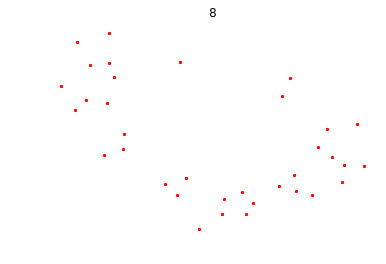

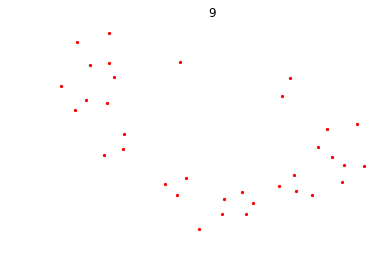

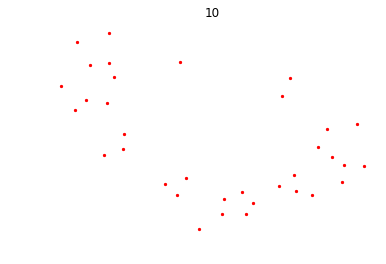

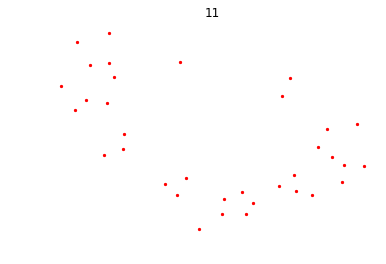

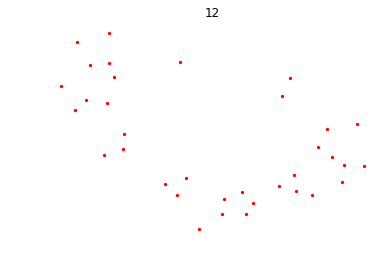

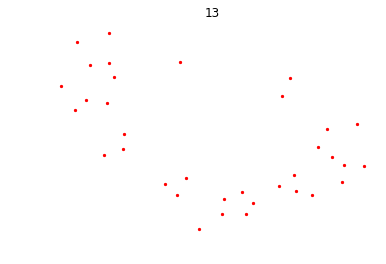

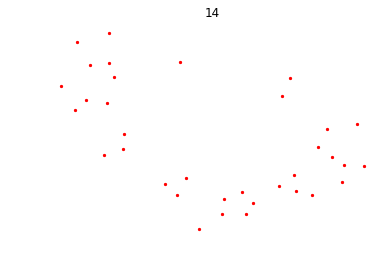

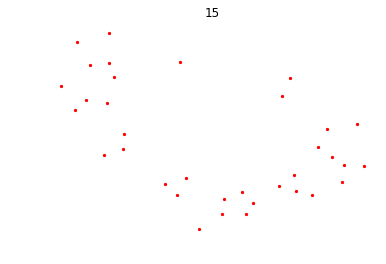

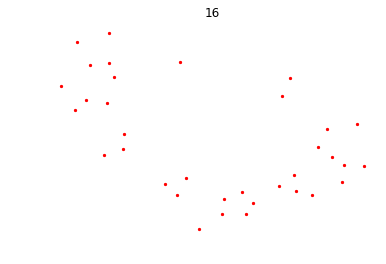

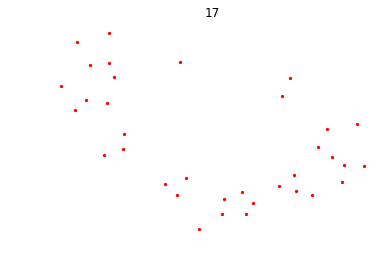

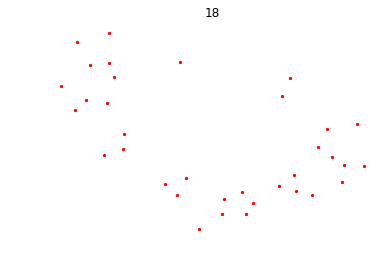

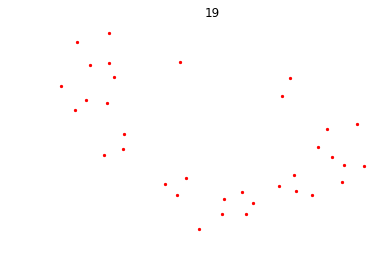

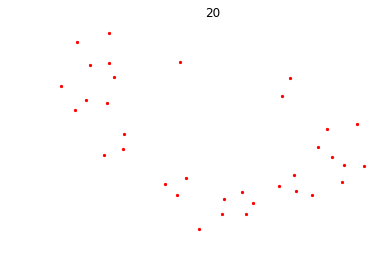

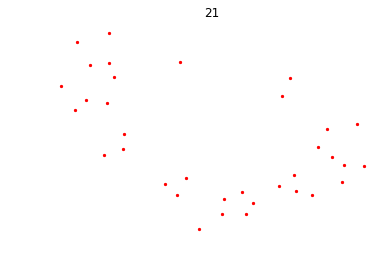

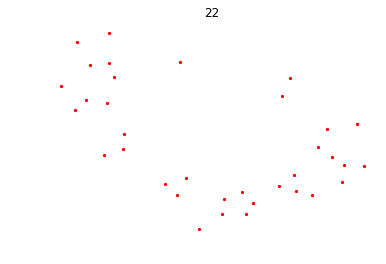

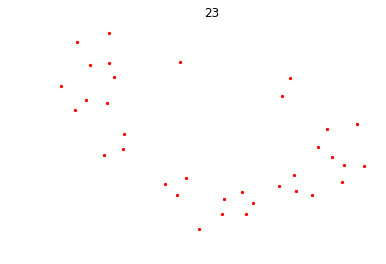

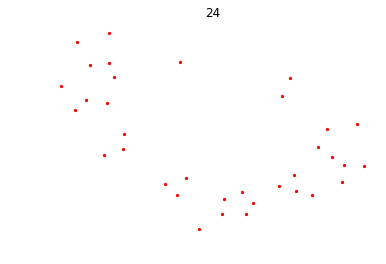

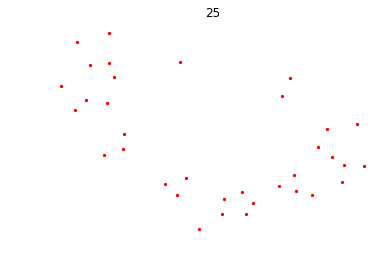

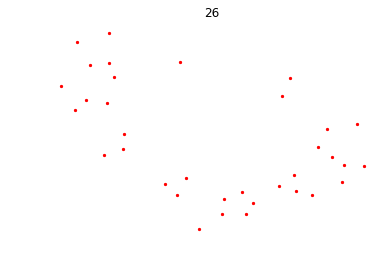

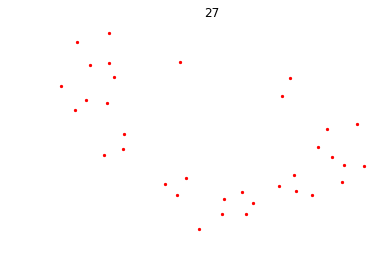

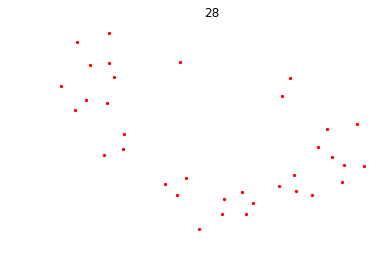

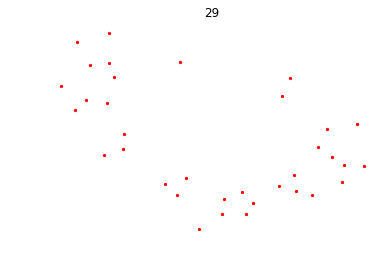

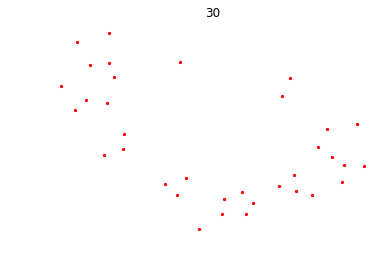

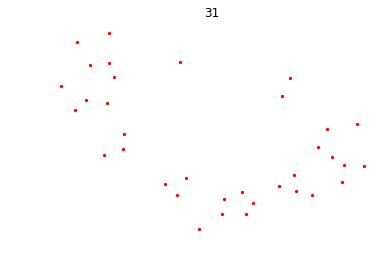

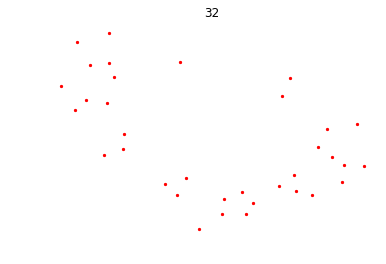

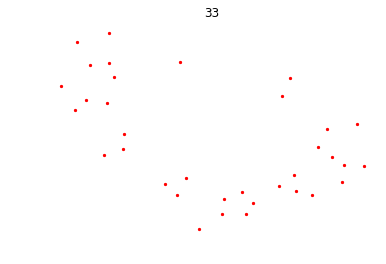

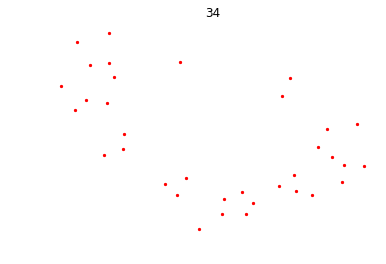

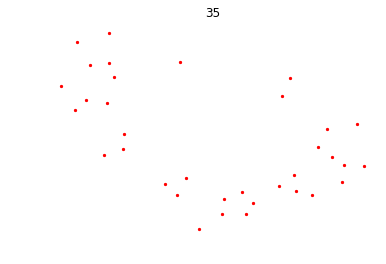

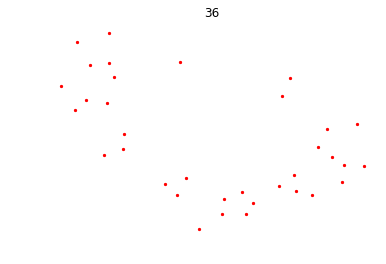

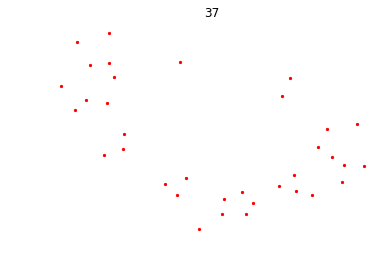

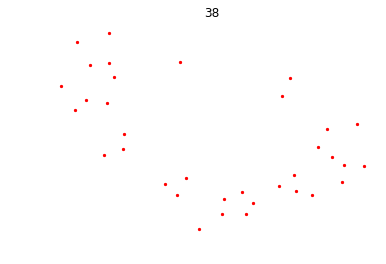

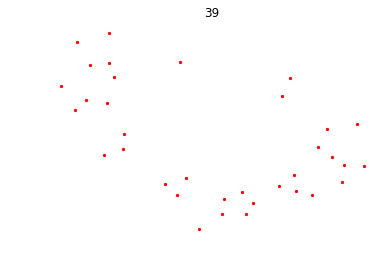

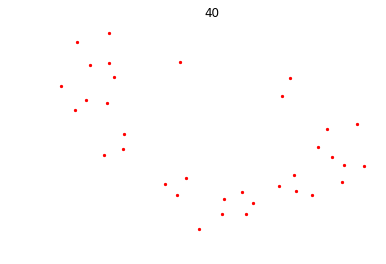

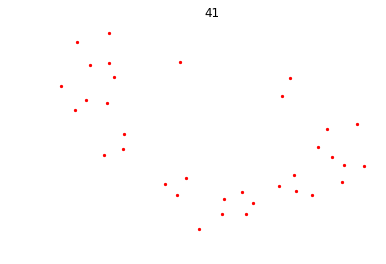

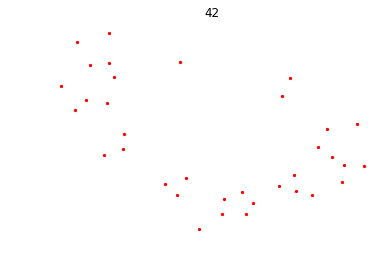

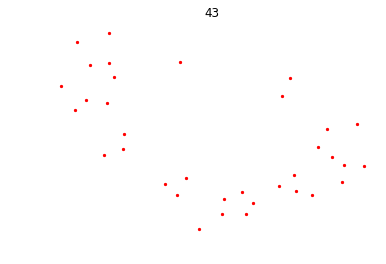

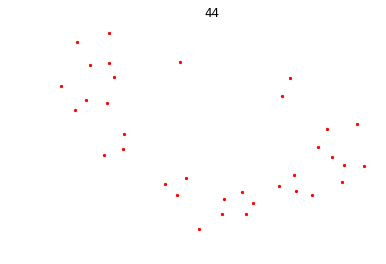

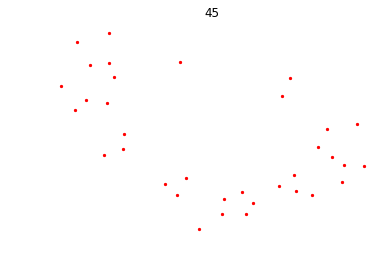

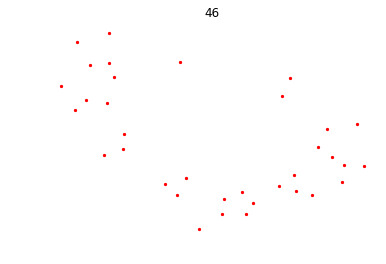

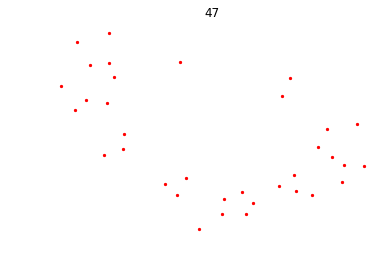

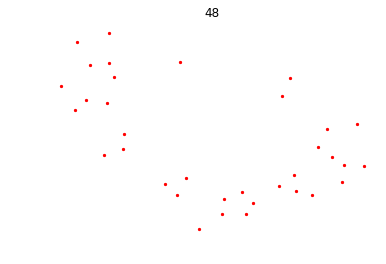

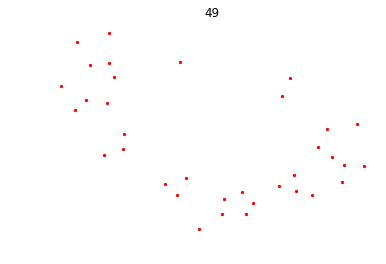

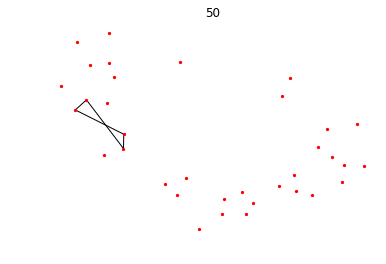

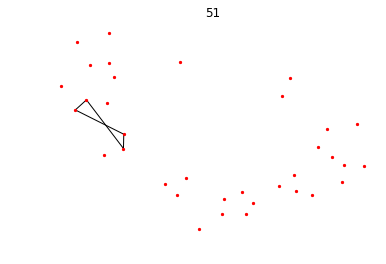

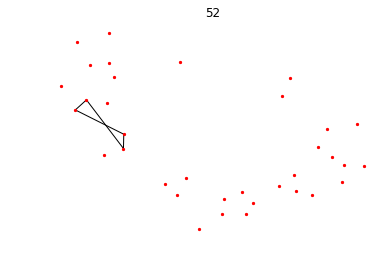

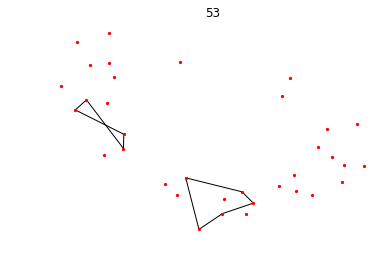

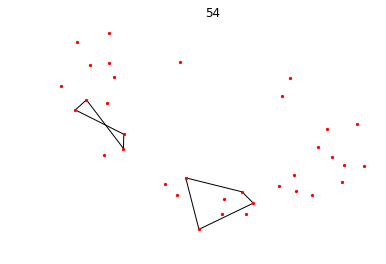

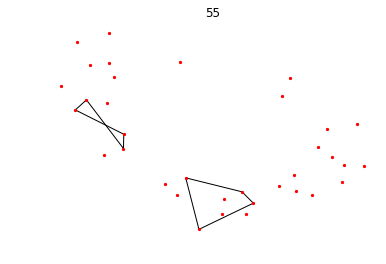

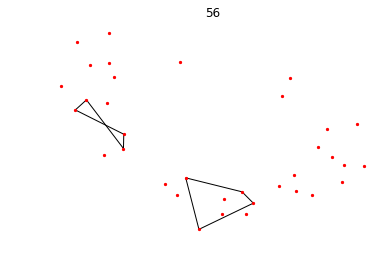

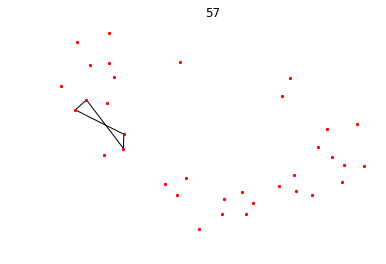

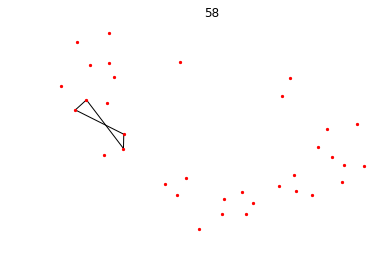

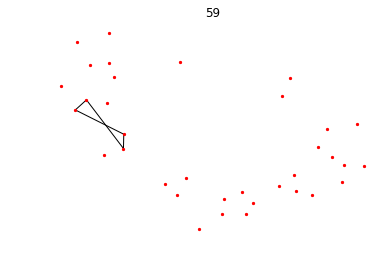

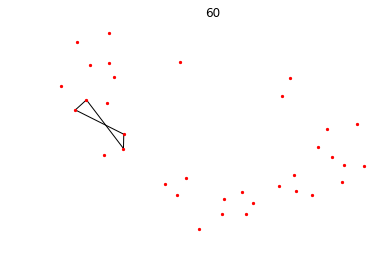

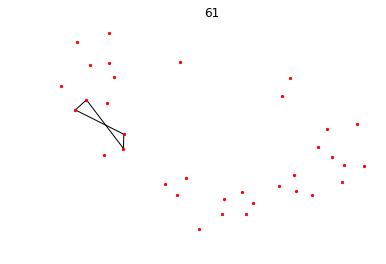

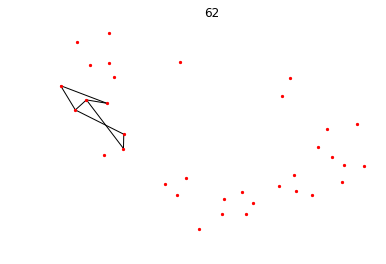

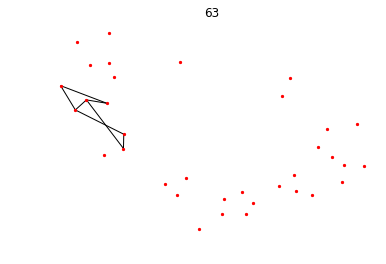

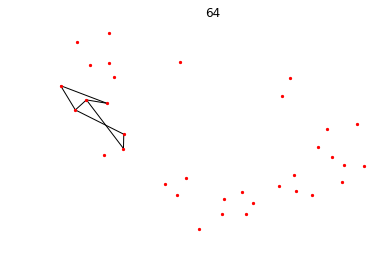

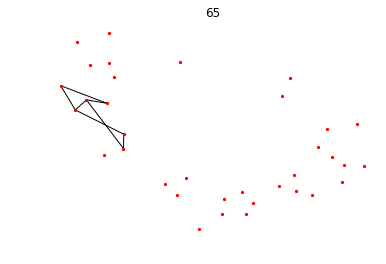

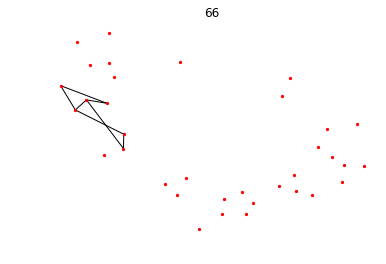

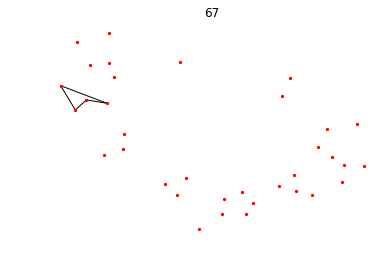

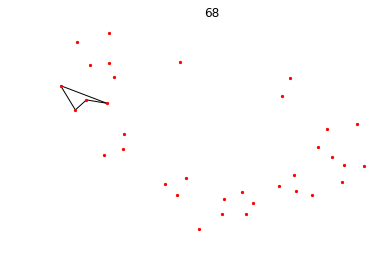

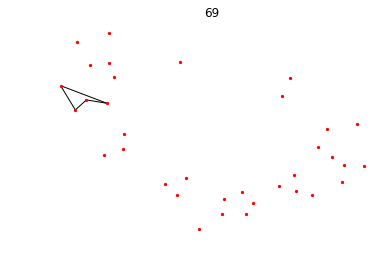

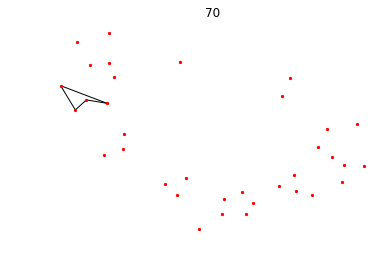

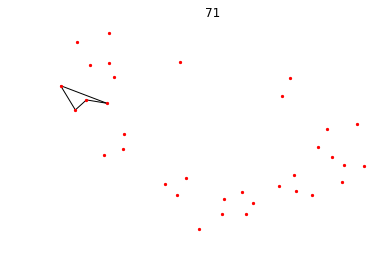

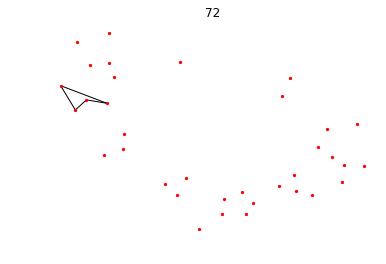

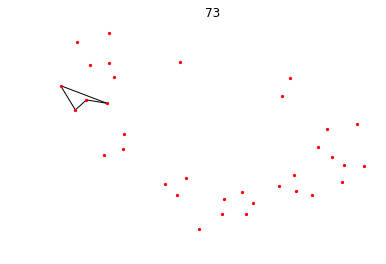

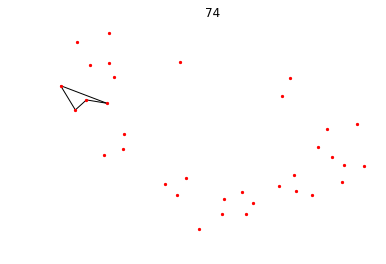

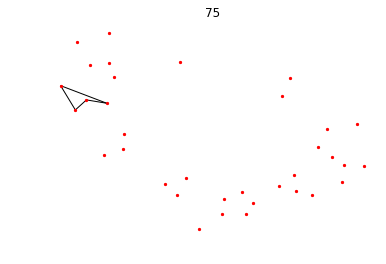

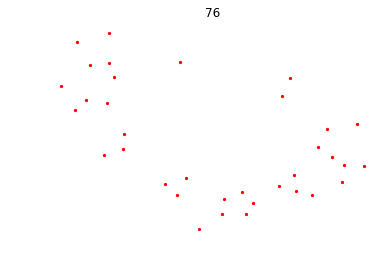

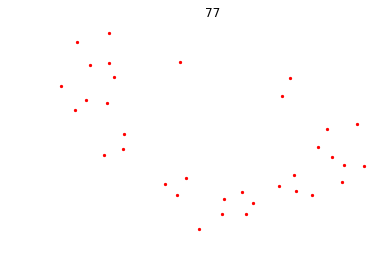

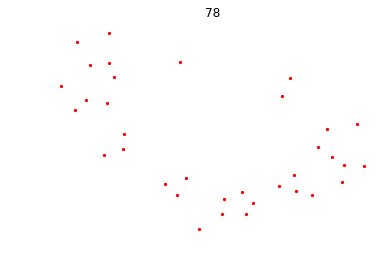

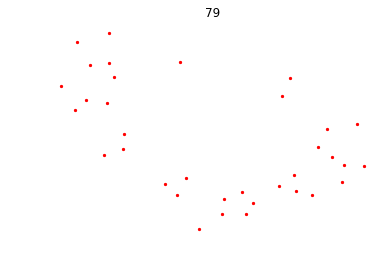

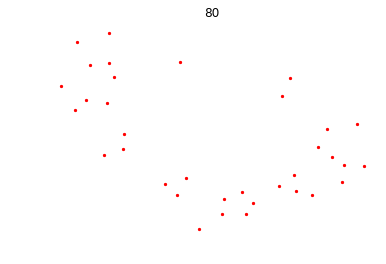

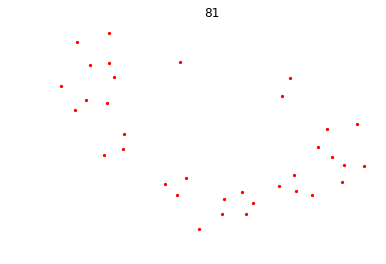

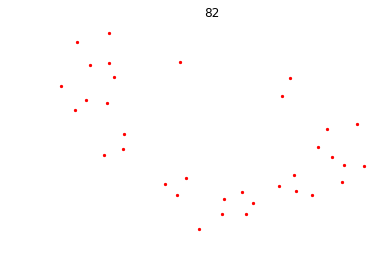

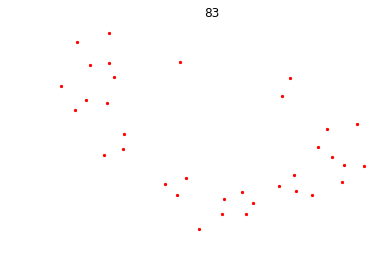

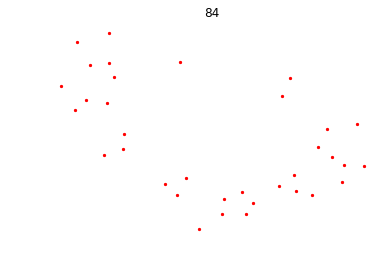

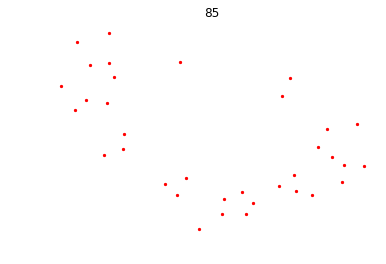

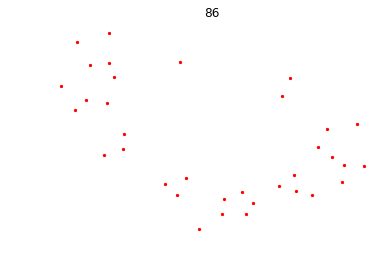

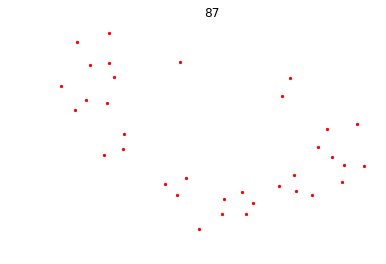

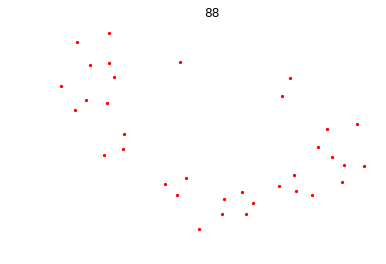

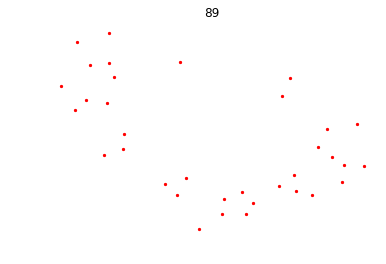

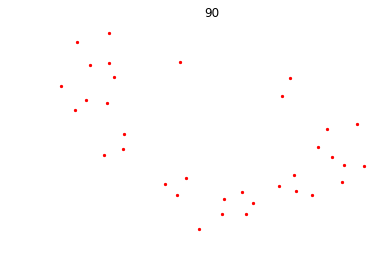

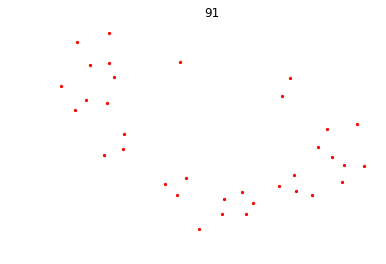

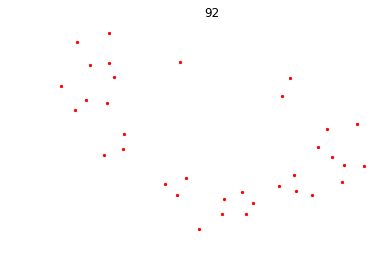

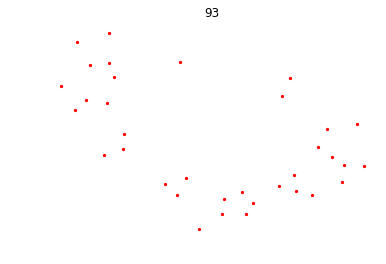

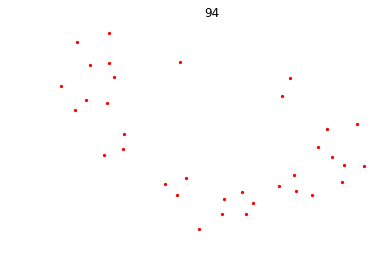

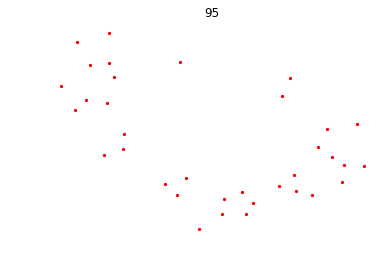

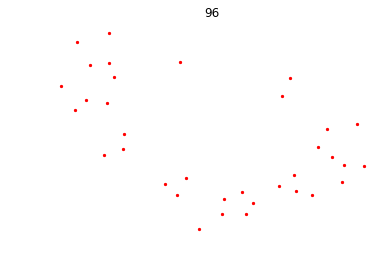

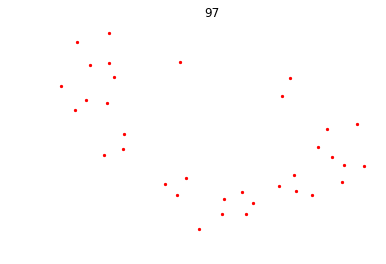

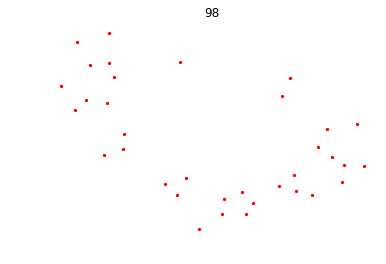

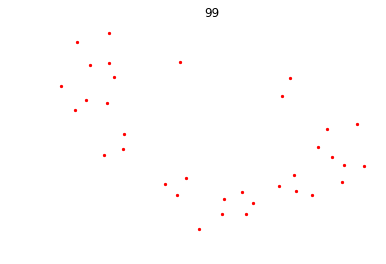

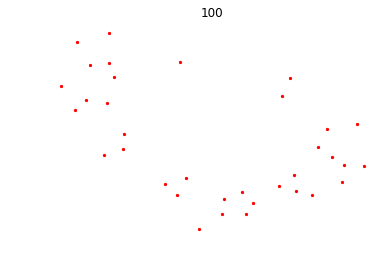

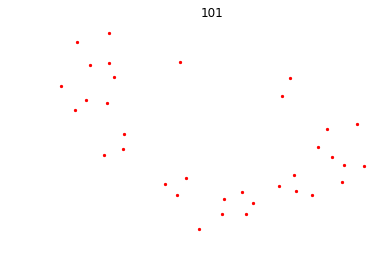

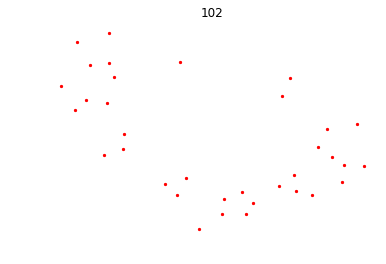

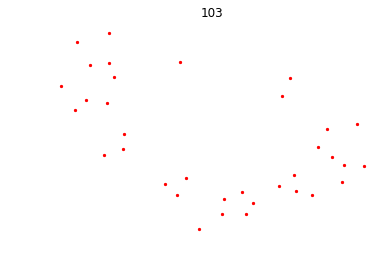

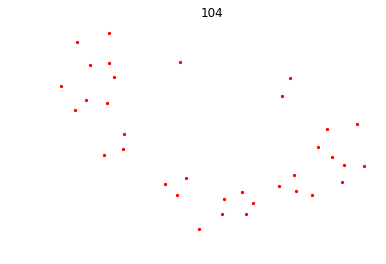

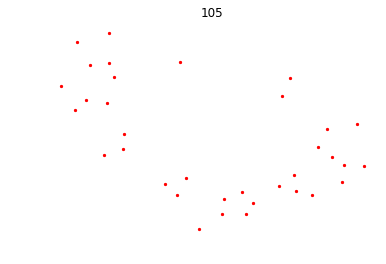

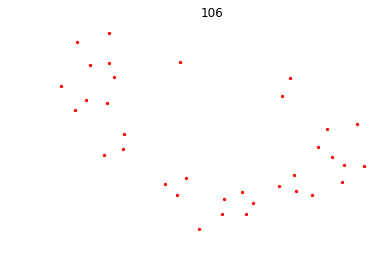

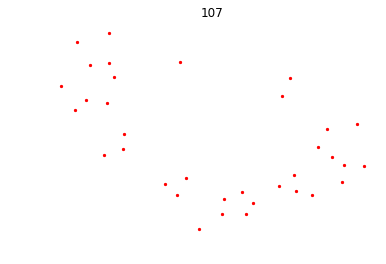

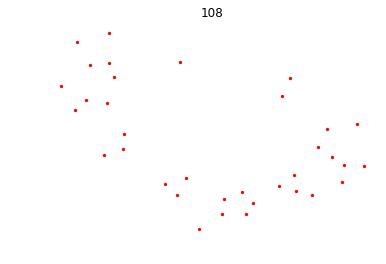

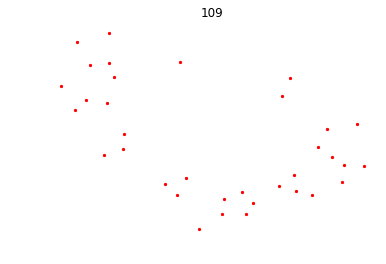

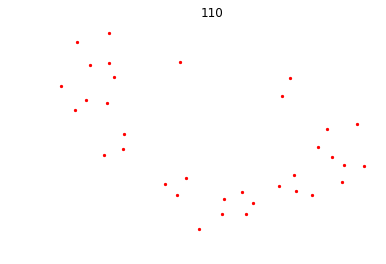

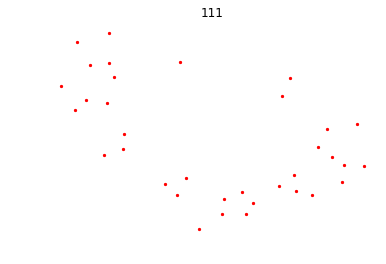

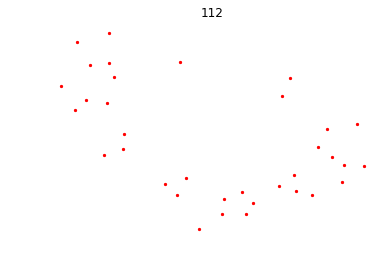

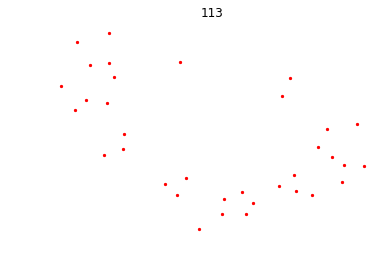

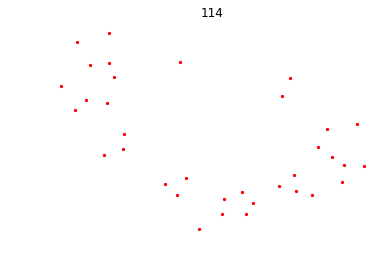

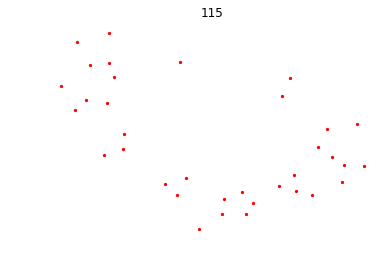

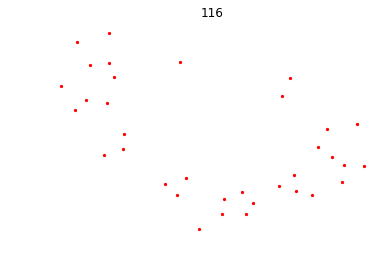

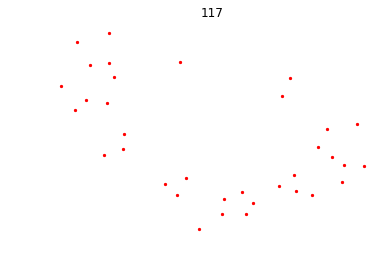

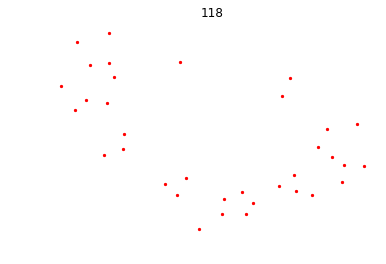

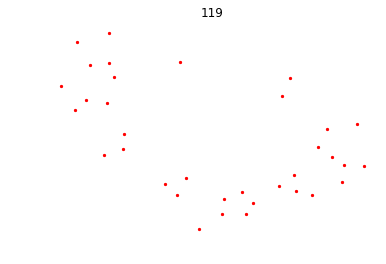

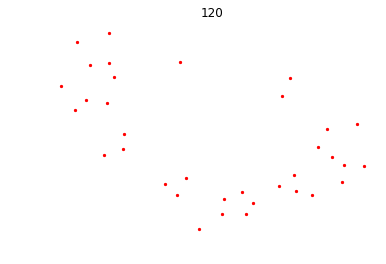

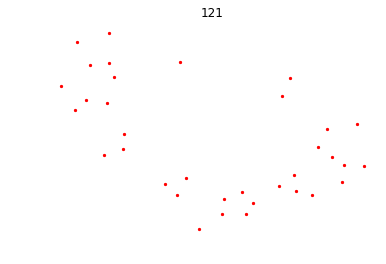

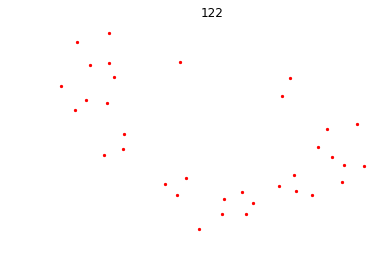

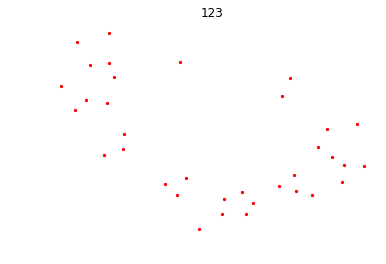

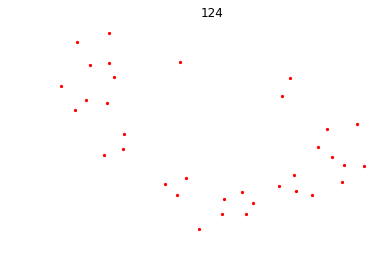

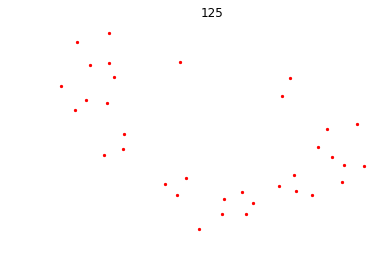

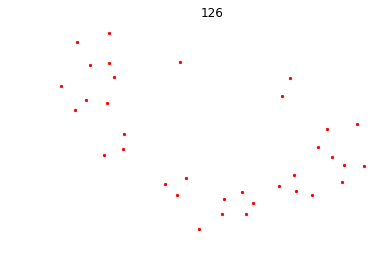

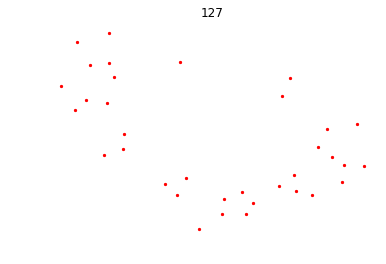

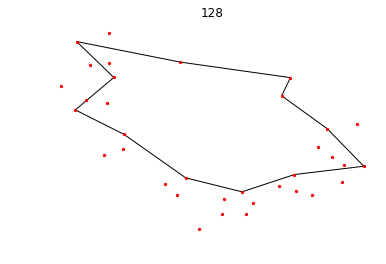

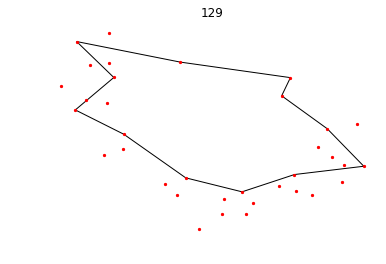

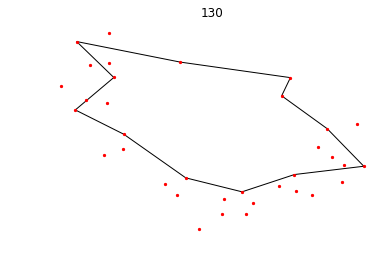

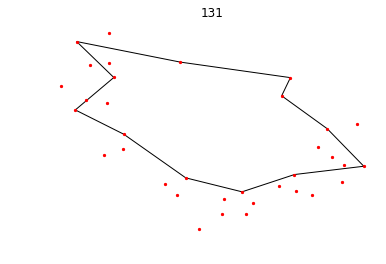

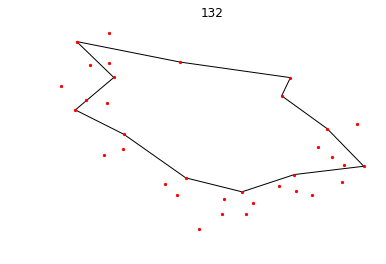

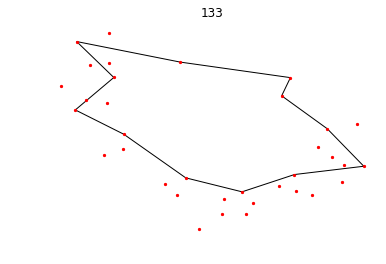

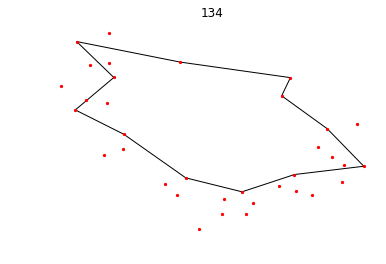

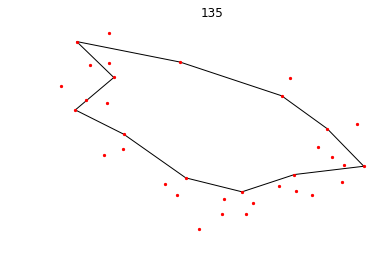

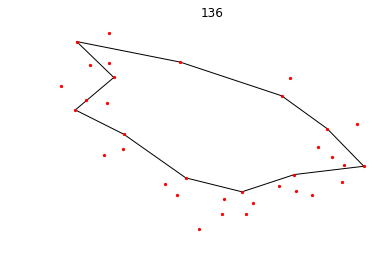

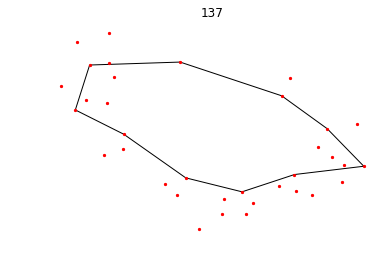

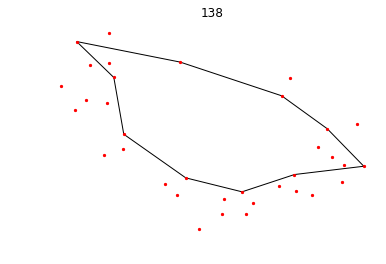

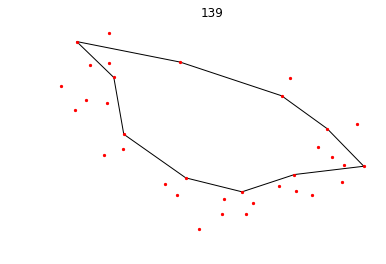

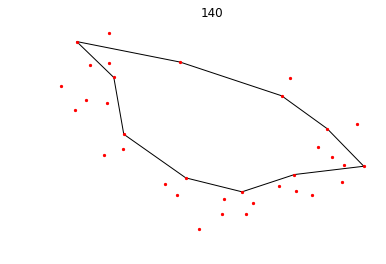

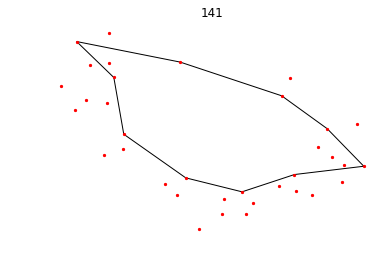

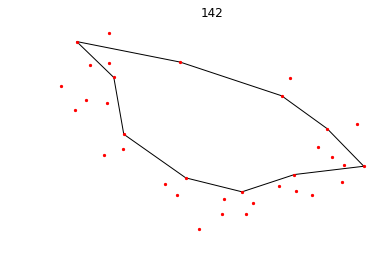

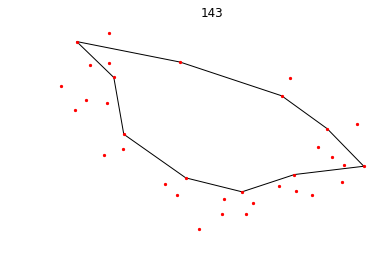

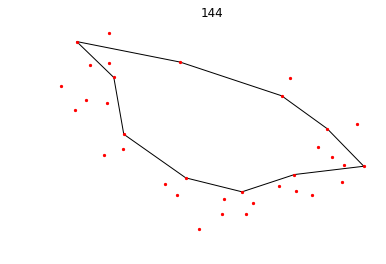

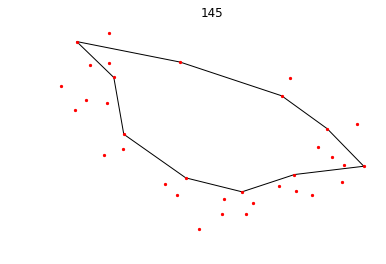

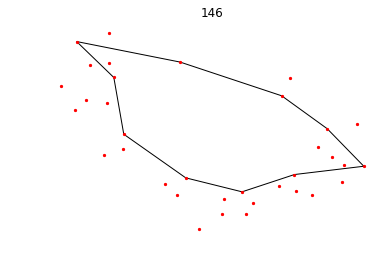

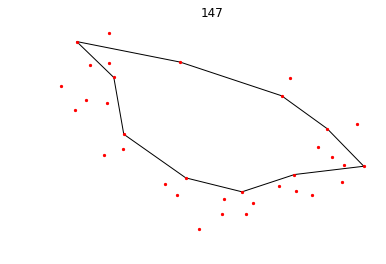

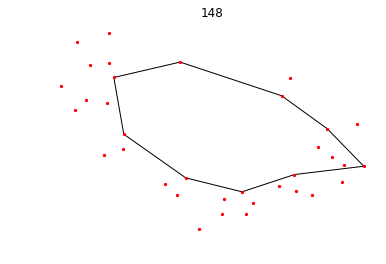

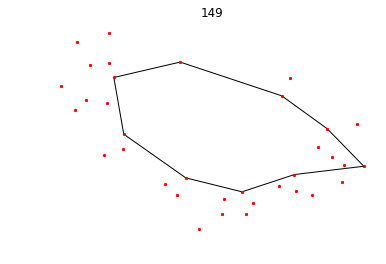

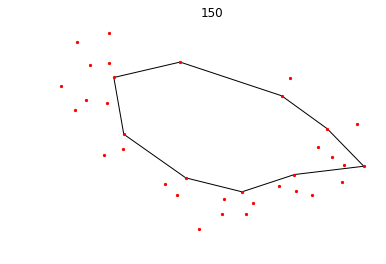

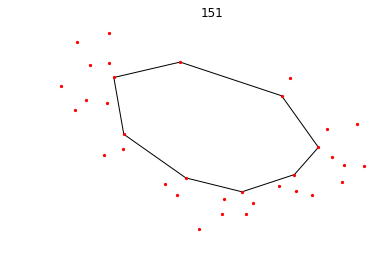

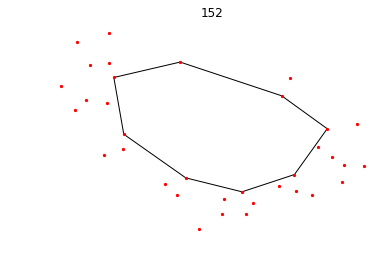

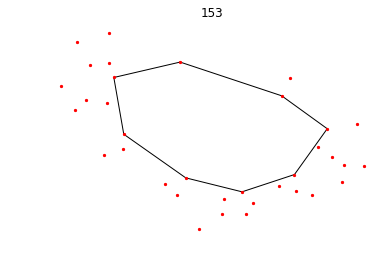

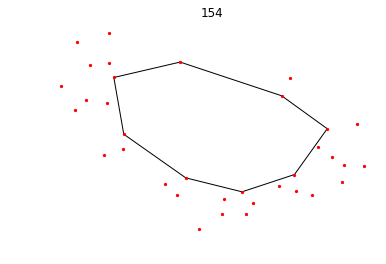

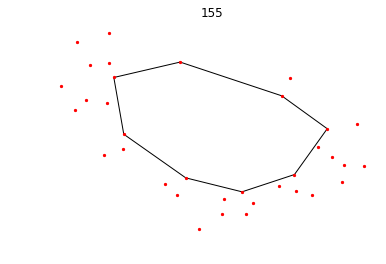

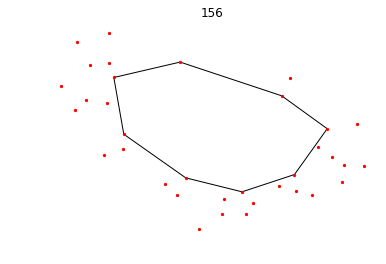

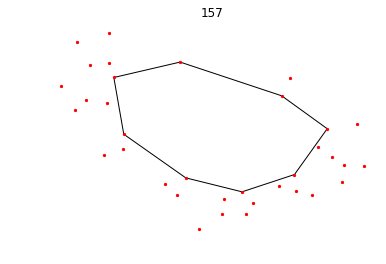

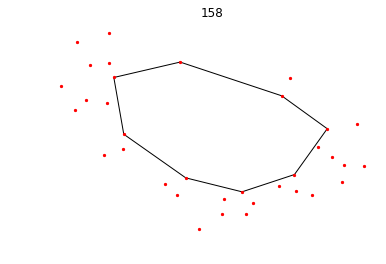

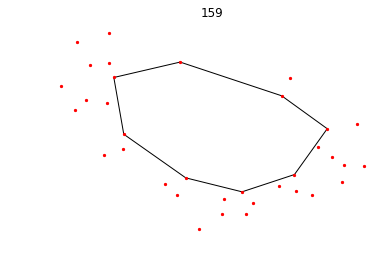

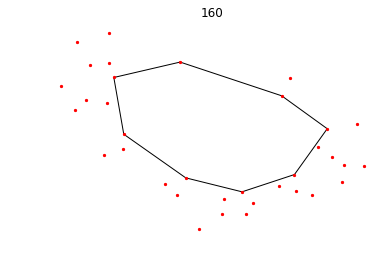

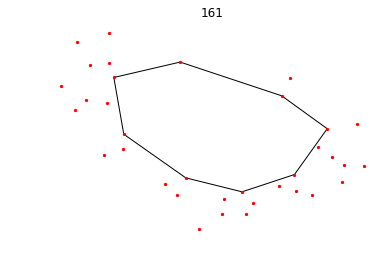

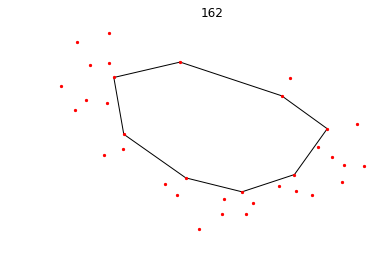

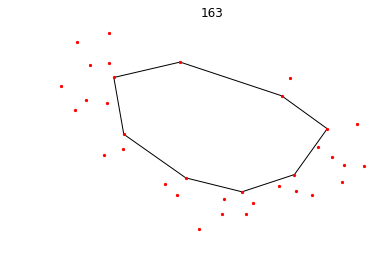

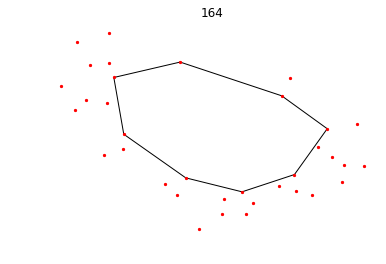

In [30]:
i = 0
for (e,B) in F.Elements:
    i += 1
    fig , ax1= plt.subplots()
    M = Scaffold.matrix_Basis( B , NV , np.array(F.get_edgeList()) )
    nx.draw( nx.Graph(M) , pos = layout , node_size=5, ax=ax1 )
    plt.title(i)
    plt.show()

<a id="Draws"></a>
### Uniqueness of the Minimal Basis
There are two kinds of issues affecting the uniqueness of the minimal representatives of a basis of $H_1$: <br>
1.  In the simple case, it could happen that several cycles exist which generate the same homology class and all have the same **minimal** length. This relatively tame circumstance is handled by the algorithm: if the argument `Draws=True` is passed to the function `Driver.getFiltrBasis`, then **all equally minimal representatives are saved for each homology basis cycle, for each filtration step**. The class `Geometry.Basis` is designed to treat this case transparently when constructing the scaffold, dividing equally the weight of the homology basis cycle among its variants. Conversely, when `Draws=False` the algorithm return the first instance of a minimal basis cycle it finds.
2.  Another issue arises in particular configurations where three (or $n$) cycles **of the same length** are homologically generated by two (or less than $n$) of them. In this case (which is rather pathological and unlikely in practice), several minimal bases exist and there is currently no way to work around this issue. What our eyes see as "different cycles" is in fact the same cycle for homology theory. Which generator is chosen, if the minimality criterion were to fail as well, depends on the input ordering.

Notice that flagging `Draws=True` can, in cases, increase the size of the output significantly.

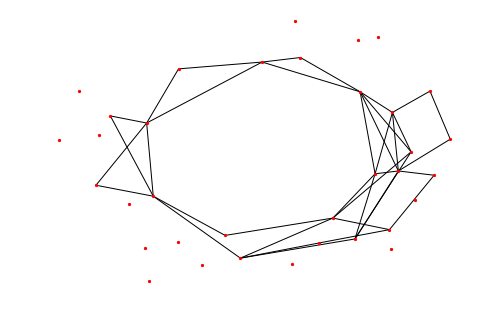

In [5]:
# set flag Draws = True
F1 = Driver.getFiltrBasis(W, epsList, Draws=True, parallel=False, monitor=None)

# Build the scaffold accounting for draws
S1 = Scaffold.frequency_Scaffold(F1 , NV)
Scaf1 = nx.from_numpy_matrix(S1, parallel_edges=False)
nx.draw(Scaf1,pos=layout, node_size=5)

<a id="Parallel"></a>
### Parallel computation
Given the computational complexity of Dey's algorithm, we have implemented a multithreaded version. Function `Driver.getFiltrBasis` can be passed arguments `parallel=True`: in this case, each step $\varepsilon$ of the filtration is treated independently, and the computation of the minimal basis $b_i$ at step $\varepsilon$ is sent to a different thread. <br>
The library, therefore, depends on the `multiprocessing` package. Notice this approach is intended for shared-memory, multiprocessor architectures that are found on ordinary desktop workstations, and not for a fully distributed architecture. <br>
Due to the nature of Dey's algorithm, the construction of the minimal basis itself cannot be further parallelized. Depending on the number of logical cores of the machine in use, the `parallel` flag can provide a noticeable improvement; however, the computational bottleneck remains the construction of a minimal basis for those filtration steps where homology is abundant. Therefore, choosing to run the library on a massively multithreaded machine *does not imply a linear speed-up in computation times*. <br><br>
If `parallel=True` is set, flag `monitor` can be passed the path of a text file. In this case, a file pipe is set up which allows threads to report information back to the parent process, hence allowing to monitor the progress of the computation. If, for example, we set `monitor='./monitor.txt'`, we can probe the progression of the algorithm by printing the content of the file in a console (`cat ./monitor.txt`). <br>
Setting `monitor=None` disables monitoring. If `parallel=False`, flag `monitor` is inactive. <br><br>
**Warning:** If the filtration is very long, the multithreading system may try to open a large number of processes at the same time. If monitoring is active, this could imply that a large number of pipes is created, exceeding the maximum number of open files that your OS is willing to accept, and resulting in an error like `IOError: [Errno 24] Too many open files`. In some cases, and depending on your OS, this could be worked around by increasing the limit number of open files to $X$ by `'ulimit -n X'`.

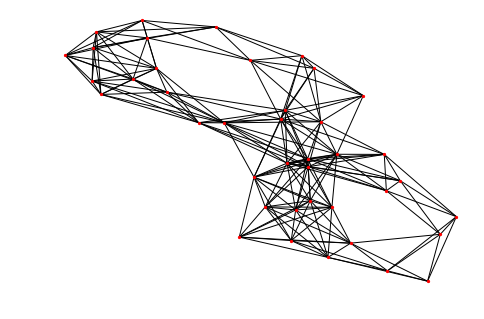

In [10]:
P2 = []
P2 = Driver.sampleCircle(0,0,3,20,0)
P2 += Driver.sampleCircle(8,0,3,20,0)

W2,_ = Driver.points2adj(P2,4)

G2 = nx.Graph(W2) # create a nx object

# Fix a layout for graph G. Node positions are chosen trying to minimize edge crossings.
layout2 = nx.drawing.layout.spring_layout(G2)

# Plot the input weighted graph.
nx.draw(G2, pos=layout2, node_size=5)

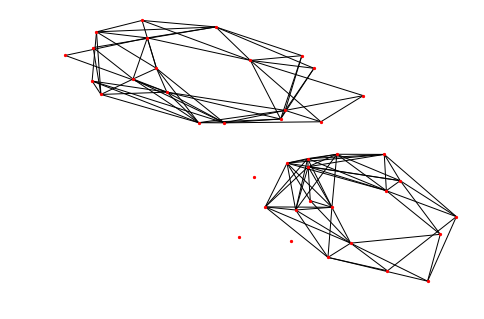

In [15]:
epsList2 = Geometry.genFullEpsList(W2)
#monitor='./monitor'
F2 = Driver.getFiltrBasis(W2, epsList2, Draws=False, parallel=True,monitor=None)

# Build the scaffold accounting for draws
S2 = Scaffold.frequency_Scaffold(F2 , len(P2))
Scaf2 = nx.from_numpy_matrix(S2, parallel_edges=False)
nx.draw(Scaf2,pos=layout2, node_size=5)

<a id="HolesDependencies"></a>
### Dependencies for Holes
Hello 666

# Now using Holes!

In [18]:
sys.path.append('./Holes/')
import Holes as ho

fil = ho.filtrations.upward_limited_weight_clique_rank_filtration(G,3)
clique_dictionary_file = './test_filtration.pck'
pk.dump(fil,open(clique_dictionary_file,'wb'), protocol=2)

hom_dim = 1 # max homology group calculated
dataset_tag = 'test_'
output_dir = './CElegans';

ho.persistent_homology_calculation(clique_dictionary_file, hom_dim, dataset_tag, output_dir,m1=512, m2=2048,save_generators=True)

Preliminary scan of edge weights to define filtration steps...
Constructing filtration...
Max filtration value: 182
Clique dictionary created.
Calling: jython  /Users/marco/Desktop/PhD/SHB/Scaffold_Release/MinScaffold/Holes/jython_utils/persistent_homology_calculation.py ./test_filtration.pck 1 ./CElegans test__ /Users/marco/javaplex/ True
0


Child returned 0


In [19]:
gen_file = './CElegansgen/generators_test__.pck'
gen = pk.load(open(gen_file, 'rb'))

ScafH = nx.Graph()
ScafH.add_nodes_from(G)

edges = []

for c in gen[1]:
    edges.extend(c.cycles())
    
for e in edges:
    u , v = int(e[0]) , int(e[1])
    if ScafH.has_edge(u,v):
        ScafH[u][v]['weight'] += 1
    else:
        ScafH.add_edge(u, v, weight=1)
        

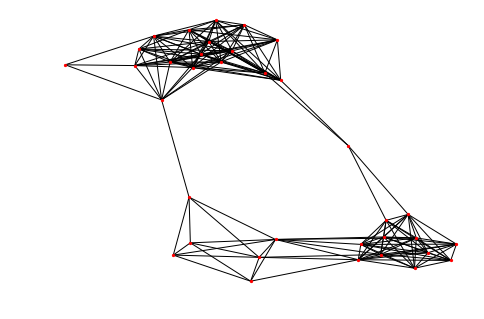

In [20]:
# layout was defined up at the beginning!
nx.draw(G, pos=layout, node_size=5)

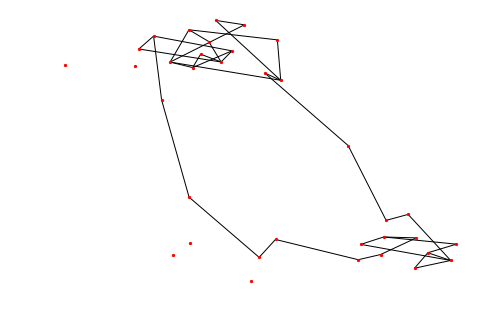

In [21]:
nx.draw(ScafH, pos=layout, node_size=5)

In [22]:
len(gen[1])

5

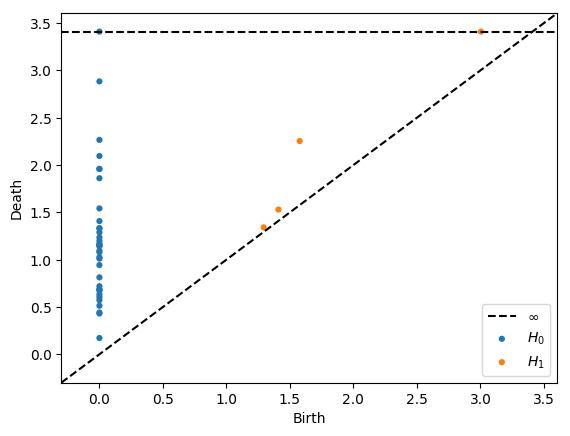

In [20]:
from ripser import ripser, plot_dgms

A = nx.adjacency_matrix(G)

diagrams = ripser(A,distance_matrix=True)['dgms']
plot_dgms(diagrams)

## Compare the two scaffolds!

Original edges: 214 - With Holes: 42 - Minimal Scaffold: 46


matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0., 13.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 13.,  0.,  0.]])

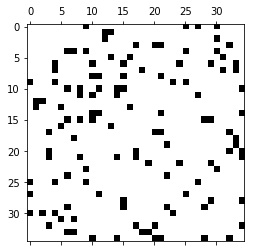

In [11]:
print( 'Original edges: ' + str(G.number_of_edges()) + ' - With Holes: ' + str(ScafH.number_of_edges()) +
      ' - Minimal Scaffold: ' + str(Scaf.number_of_edges()) )

SH = nx.adjacency_matrix(ScafH, weight='weight')
SH = np.matrix(SH.todense())
Diff = np.abs(SH - S)
plt.spy(Diff)
Diff

/home/marco/.local/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


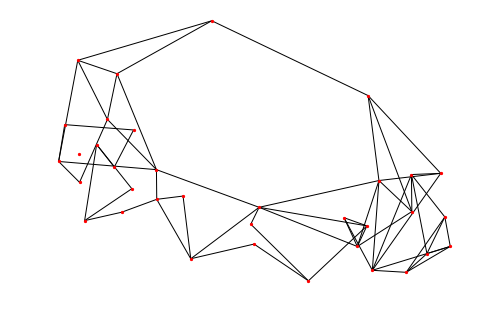

In [12]:
D = nx.Graph(Diff)
nx.draw(D , pos = layout, node_size=5)

In [13]:
ScafH.number_of_edges()

42

In [14]:
Scaf.number_of_edges()

46

/home/marco/.local/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


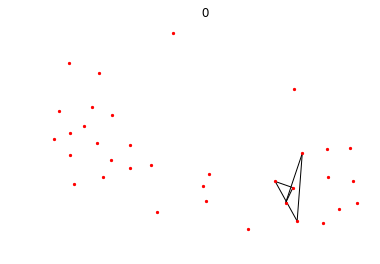

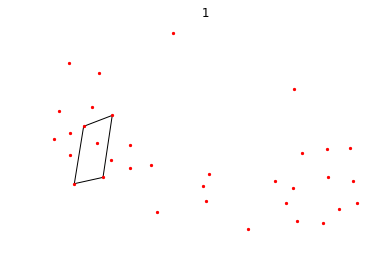

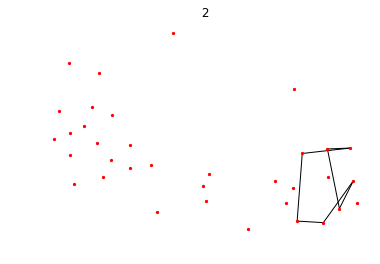

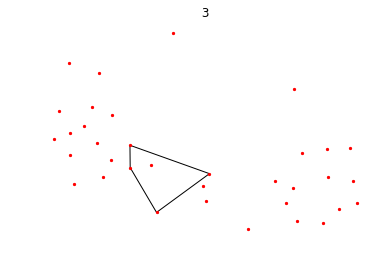

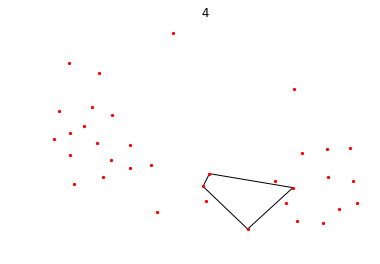

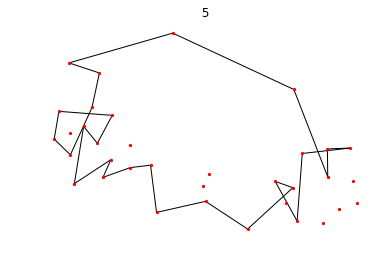

In [15]:
for i,c in enumerate(gen[1]):
    fig , tuma = plt.subplots()
    edges = c.cycles()
    SS = nx.Graph()
    SS.add_nodes_from(G)
    for e in edges:
        u , v = int(e[0]) , int(e[1])
        SS.add_edge(u, v, weight=1)
    plt.title( ' '+str(i) + ' '  )
    nx.draw(SS, pos = layout , node_size=5, ax=tuma )
    
    

## RIPSER
Let us use the "fast" persistence algorithm in ripser to obtain the barcode. We want to do so to compute the "bounds" in the filtration outside of which the $H_1$ homology is trivial. This way we can avoid useless computations of trivil homology groups

In [31]:
import ripser
import scipy

G = nx.read_weighted_edgelist('./CElegans/celegans_weighted_undirected.edges')
# converto to weighted adj matrix
W = nx.adjacency_matrix(G,weight='weight')
W = W.power(-1)

#W = np.reciprocal(W) # will complain about division by zero
#W[W==np.inf] = 0 # revert inf to zeros

#r = ripser.ripser(W,distance_matrix=True)
#ripser.plot_dgms(r['dgms'])
w = W.todense().flatten()
len(w)

1

In [36]:
# READ THE DATASET
G = nx.read_weighted_edgelist('./CElegans/celegans_weighted_undirected.edges')
# converto to weighted adj matrix
W = nx.adjacency_matrix(G,weight='weight').todense()
# weigts you need to invert
W = np.reciprocal(W) # will complain about division by zero
W[W==np.inf] = 0 # revert inf to zeros
W = np.matrix(W)
#Testing suggests it works all right

# now the heavy-lifting!
#epsList = Geometry.genFullEpsList(W) # get the filtration

vals = np.ndarray.flatten(W)
vals = vals.tolist()
while type(vals[0]) is not float:
    vals = vals[0]
#print(vals)
vals = np.unique(vals).tolist()
#vals.tolist()
print(vals)


# vals = list(set(vals))
# vals = sorted(vals)
# vals = [ x + 0.001 for x in vals ]


[0.0, 0.014285714285714285, 0.01639344262295082, 0.022727272727272728, 0.03225806451612903, 0.03333333333333333, 0.034482758620689655, 0.03571428571428571, 0.037037037037037035, 0.04, 0.041666666666666664, 0.043478260869565216, 0.045454545454545456, 0.05263157894736842, 0.05555555555555555, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.07142857142857142, 0.07692307692307693, 0.08333333333333333, 0.09090909090909091, 0.1, 0.1111111111111111, 0.125, 0.14285714285714285, 0.16666666666666666, 0.2, 0.25, 0.3333333333333333, 0.5, 1.0]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in reciprocal
  


In [21]:
data = np.load('CElegans/CEFullNoDraws.dat')
data[7]['SHB']

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [8]:
import scipy.stats

scipy.stats.spearmanr

function

In [3]:
G = nx.read_weighted_edgelist('./CElegans/celegans_weighted_undirected.edges')

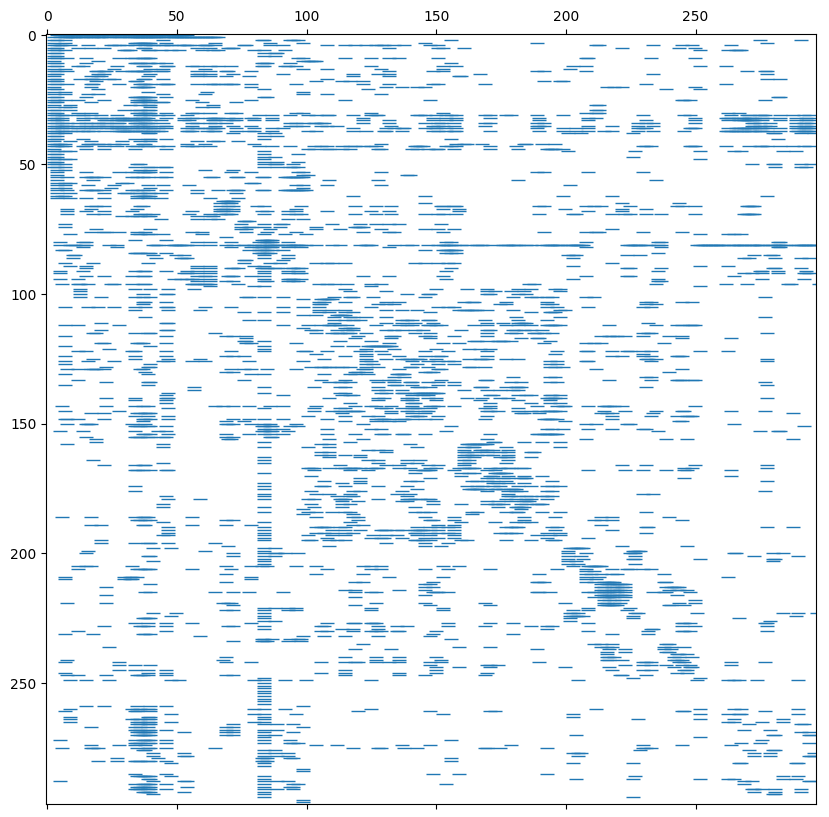

In [15]:
A = nx.adjacency_matrix(G)

#A = np.reciprocal(A) # will complain about division by zero
#A[A==np.inf] = 0 # revert inf to zeros

plt.figure(figsize=(10,10))
plt.spy(A,marker=True, antialiased=True)

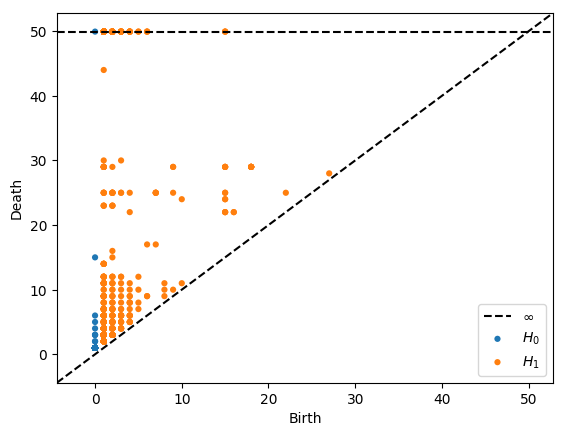

In [16]:
from ripser import ripser, plot_dgms

diagrams = ripser(A,distance_matrix=True)['dgms']
plot_dgms(diagrams)